In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.stats import zscore
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Patients_Data.xlsx')
df.head()

,PatientID,State,Sex,GeneralHealth,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack,HadAngina,...,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,1,Alabama,Female,Fair,Age 75 to 79,1.63,84.820000,32.099998,0,1,...,Never used e-cigarettes in my entire life,1,"White only, Non-Hispanic",0,0,0,1,"No, did not receive any tetanus shot in the pa...",0,1
1,2,Alabama,Female,Very good,Age 65 to 69,1.60,71.669998,27.990000,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received Tdap",0,0
2,3,Alabama,Male,Excellent,Age 60 to 64,1.78,71.209999,22.530001,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",1,0,0,0,"Yes, received tetanus shot but not sure what type",0,0
3,4,Alabama,Male,Very good,Age 70 to 74,1.78,95.250000,30.129999,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received tetanus shot but not sure what type",0,0
4,5,Alabama,Female,Good,Age 50 to 54,1.68,78.019997,27.760000,0,0,...,Never used e-cigarettes in my entire life,1,"Black only, Non-Hispanic",0,0,1,0,"No, did not receive any tetanus shot in the pa...",0,0


In [3]:
def find_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

In [4]:
numerical_cols = df.select_dtypes(include=np.number).columns
outliers = {}
for col in numerical_cols:
    outliers[col] = find_outliers_iqr(df[col])

for col, outlier_values in outliers.items():
    print(f"Outliers in column '{col}':\n{len(outlier_values)}\n")

Outliers in column 'PatientID':
0

Outliers in column 'HeightInMeters':
813

Outliers in column 'WeightInKilograms':
5787

Outliers in column 'BMI':
7376

Outliers in column 'HadHeartAttack':
13201

Outliers in column 'HadAngina':
14617

Outliers in column 'HadStroke':
9928

Outliers in column 'HadAsthma':
35292

Outliers in column 'HadSkinCancer':
20252

Outliers in column 'HadCOPD':
18602

Outliers in column 'HadDepressiveDisorder':
48896

Outliers in column 'HadKidneyDisease':
11029

Outliers in column 'HadArthritis':
0

Outliers in column 'DeafOrHardOfHearing':
20540

Outliers in column 'BlindOrVisionDifficulty':
11987

Outliers in column 'DifficultyConcentrating':
25501

Outliers in column 'DifficultyWalking':
35391

Outliers in column 'DifficultyDressingBathing':
8204

Outliers in column 'DifficultyErrands':
16056

Outliers in column 'ChestScan':
0

Outliers in column 'AlcoholDrinkers':
0

Outliers in column 'HIVTesting':
0

Outliers in column 'FluVaxLast12':
0

Outliers in colum

In [5]:
numerical_features = df.select_dtypes(include=np.number)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(numerical_features), columns=numerical_features.columns)
print("\nData after Z-score normalization:\n")
df_scaled.head()


Data after Z-score normalization:



,PatientID,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,-1.732044,-0.702312,0.053935,0.522115,-0.242529,3.906034,-0.208808,2.394421,3.276226,-0.291427,...,2.390485,-0.1891,-0.26919,1.158552,-1.095070,-0.722058,-1.065986,1.206752,-0.211515,1.542425
1,-1.732029,-0.983273,-0.561675,-0.107475,-0.242529,-0.256014,-0.208808,-0.417637,-0.305229,-0.291427,...,-0.418325,-0.1891,-0.26919,-0.863146,-1.095070,-0.722058,0.938099,1.206752,-0.211515,-0.648330
2,-1.732014,0.702498,-0.583210,-0.943865,-0.242529,-0.256014,-0.208808,-0.417637,-0.305229,-0.291427,...,-0.418325,-0.1891,-0.26919,-0.863146,0.913184,-0.722058,-1.065986,-0.828671,-0.211515,-0.648330
3,-1.732000,0.702498,0.542209,0.220341,-0.242529,-0.256014,-0.208808,-0.417637,-0.305229,-0.291427,...,-0.418325,-0.1891,-0.26919,-0.863146,-1.095070,-0.722058,0.938099,1.206752,-0.211515,-0.648330
4,-1.731985,-0.234042,-0.264404,-0.142707,-0.242529,-0.256014,-0.208808,-0.417637,-0.305229,-0.291427,...,-0.418325,-0.1891,-0.26919,1.158552,-1.095070,-0.722058,0.938099,-0.828671,-0.211515,-0.648330


In [6]:
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col] = zscore(df[col])
print("\nData after Z-score normalization:\n")
df.head()


Data after Z-score normalization:



,PatientID,State,Sex,GeneralHealth,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack,HadAngina,...,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,-1.732044,Alabama,Female,Fair,Age 75 to 79,-0.702312,0.053935,0.522115,-0.242529,3.906034,...,Never used e-cigarettes in my entire life,1.158552,"White only, Non-Hispanic",-1.095070,-0.722058,-1.065986,1.206752,"No, did not receive any tetanus shot in the pa...",-0.211515,1.542425
1,-1.732029,Alabama,Female,Very good,Age 65 to 69,-0.983273,-0.561675,-0.107475,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,-0.863146,"White only, Non-Hispanic",-1.095070,-0.722058,0.938099,1.206752,"Yes, received Tdap",-0.211515,-0.648330
2,-1.732014,Alabama,Male,Excellent,Age 60 to 64,0.702498,-0.583210,-0.943865,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,-0.863146,"White only, Non-Hispanic",0.913184,-0.722058,-1.065986,-0.828671,"Yes, received tetanus shot but not sure what type",-0.211515,-0.648330
3,-1.732000,Alabama,Male,Very good,Age 70 to 74,0.702498,0.542209,0.220341,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,-0.863146,"White only, Non-Hispanic",-1.095070,-0.722058,0.938099,1.206752,"Yes, received tetanus shot but not sure what type",-0.211515,-0.648330
4,-1.731985,Alabama,Female,Good,Age 50 to 54,-0.234042,-0.264404,-0.142707,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,1.158552,"Black only, Non-Hispanic",-1.095070,-0.722058,0.938099,-0.828671,"No, did not receive any tetanus shot in the pa...",-0.211515,-0.648330


In [7]:
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(zscore(data))
    outliers = z_scores > threshold
    return outliers

numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    outliers = detect_outliers_zscore(df[col])
    print(f"Outliers in column '{col}':\n{len(df[col][outliers])}\n")

Outliers in column 'PatientID':
0

Outliers in column 'HeightInMeters':
520

Outliers in column 'WeightInKilograms':
2335

Outliers in column 'BMI':
2983

Outliers in column 'HadHeartAttack':
13201

Outliers in column 'HadAngina':
14617

Outliers in column 'HadStroke':
9928

Outliers in column 'HadAsthma':
0

Outliers in column 'HadSkinCancer':
20252

Outliers in column 'HadCOPD':
18602

Outliers in column 'HadDepressiveDisorder':
0

Outliers in column 'HadKidneyDisease':
11029

Outliers in column 'HadArthritis':
0

Outliers in column 'DeafOrHardOfHearing':
20540

Outliers in column 'BlindOrVisionDifficulty':
11987

Outliers in column 'DifficultyConcentrating':
0

Outliers in column 'DifficultyWalking':
0

Outliers in column 'DifficultyDressingBathing':
8204

Outliers in column 'DifficultyErrands':
16056

Outliers in column 'ChestScan':
0

Outliers in column 'AlcoholDrinkers':
0

Outliers in column 'HIVTesting':
0

Outliers in column 'FluVaxLast12':
0

Outliers in column 'PneumoVaxEver

In [8]:
def mahalanobis_distance(df):
    cov_matrix = np.cov(df.values, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    means = np.mean(df.values, axis=0)
    distances = []
    for i in range(len(df)):
        distance = mahalanobis(df.iloc[i], means, inv_cov_matrix)
        distances.append(distance)
    return distances

mahalanobis_distances = mahalanobis_distance(df_scaled)

threshold = 2

anomalies = np.array(mahalanobis_distances) > threshold
print(f"Anomalies detected using mahalanobis distance: \n")
(df[anomalies])

Anomalies detected using mahalanobis distance: 



,PatientID,State,Sex,GeneralHealth,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack,HadAngina,...,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,-1.732044,Alabama,Female,Fair,Age 75 to 79,-0.702312,0.053935,0.522115,-0.242529,3.906034,...,Never used e-cigarettes in my entire life,1.158552,"White only, Non-Hispanic",-1.095070,-0.722058,-1.065986,1.206752,"No, did not receive any tetanus shot in the pa...",-0.211515,1.542425
1,-1.732029,Alabama,Female,Very good,Age 65 to 69,-0.983273,-0.561675,-0.107475,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,-0.863146,"White only, Non-Hispanic",-1.095070,-0.722058,0.938099,1.206752,"Yes, received Tdap",-0.211515,-0.648330
2,-1.732014,Alabama,Male,Excellent,Age 60 to 64,0.702498,-0.583210,-0.943865,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,-0.863146,"White only, Non-Hispanic",0.913184,-0.722058,-1.065986,-0.828671,"Yes, received tetanus shot but not sure what type",-0.211515,-0.648330
3,-1.732000,Alabama,Male,Very good,Age 70 to 74,0.702498,0.542209,0.220341,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,-0.863146,"White only, Non-Hispanic",-1.095070,-0.722058,0.938099,1.206752,"Yes, received tetanus shot but not sure what type",-0.211515,-0.648330
4,-1.731985,Alabama,Female,Good,Age 50 to 54,-0.234042,-0.264404,-0.142707,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,1.158552,"Black only, Non-Hispanic",-1.095070,-0.722058,0.938099,-0.828671,"No, did not receive any tetanus shot in the pa...",-0.211515,-0.648330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237625,1.731985,Puerto Rico,Female,Good,Age 60 to 64,-1.264235,0.330140,1.208385,-0.242529,-0.256014,...,Not at all (right now),-0.863146,Hispanic,-1.095070,-0.722058,0.938099,-0.828671,"No, did not receive any tetanus shot in the pa...",-0.211515,-0.648330
237626,1.732000,Puerto Rico,Female,Good,Age 55 to 59,-0.046733,-0.519542,-0.556307,-0.242529,3.906034,...,Not at all (right now),-0.863146,Hispanic,-1.095070,1.384931,-1.065986,-0.828671,"Yes, received Tdap",-0.211515,-0.648330
237627,1.732014,Puerto Rico,Male,Fair,Age 45 to 49,0.421536,-0.625343,-0.888719,4.123216,3.906034,...,Not at all (right now),1.158552,Hispanic,-1.095070,1.384931,0.938099,1.206752,"Yes, received Tdap",4.727791,-0.648330
237628,1.732029,Puerto Rico,Female,Very good,Age 25 to 29,-1.264235,-1.729695,-1.509118,-0.242529,-0.256014,...,Never used e-cigarettes in my entire life,-0.863146,Hispanic,-1.095070,1.384931,-1.065986,-0.828671,"No, did not receive any tetanus shot in the pa...",-0.211515,1.542425


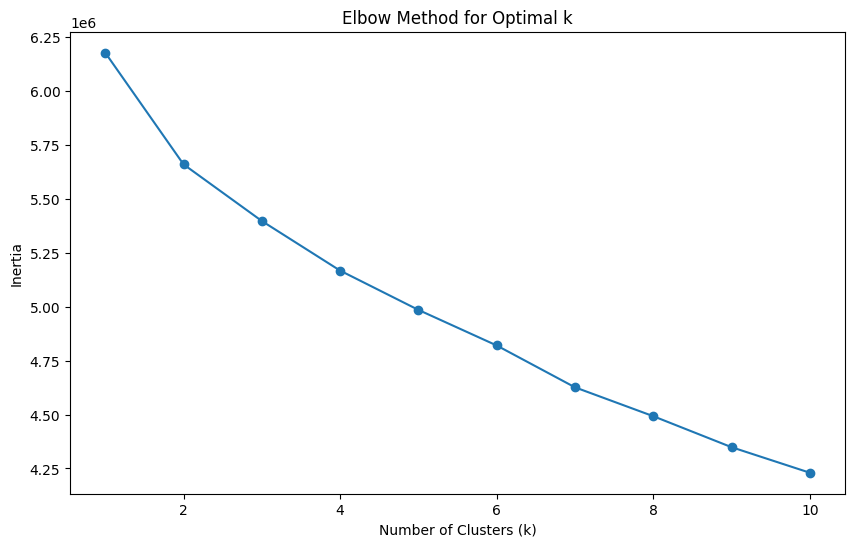

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt


inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [10]:
lof = LocalOutlierFactor(n_neighbors=2, contamination='auto')
df['lof_scores'] = lof.fit_predict(df_scaled)
df['lof_scores'] = df['lof_scores'].map({1:0,-1:1})

In [11]:
# Isolation Forest
isolation_forest = IsolationForest(contamination='auto', random_state=42) # Adjust contamination as needed
df['isolation_forest_scores'] = isolation_forest.fit_predict(df_scaled)
df['isolation_forest_scores'] = df['isolation_forest_scores'].map({1:0,-1:1}) # map the output to 0 and 1

In [15]:
print("\nComparison of Anomaly Detection Methods:\n")
print("LOF:\n", df['lof_scores'].value_counts())
print("\nIsolation Forest:\n", df['isolation_forest_scores'].value_counts())


Comparison of Anomaly Detection Methods:

LOF:
 lof_scores
0    216849
1     20781
Name: count, dtype: int64

Isolation Forest:
 isolation_forest_scores
0    179223
1     58407
Name: count, dtype: int64



Comparison of Anomaly Detection Methods:

LOF:
 lof_scores
0    216849
1     20781
Name: count, dtype: int64

Isolation Forest:
 isolation_forest_scores
0    179223
1     58407
Name: count, dtype: int64


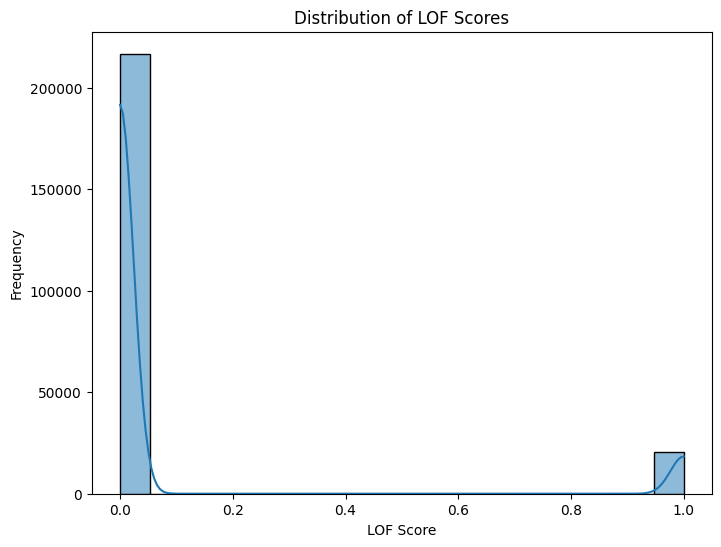

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(df['lof_scores'], kde=True)
plt.title("Distribution of LOF Scores")
plt.xlabel("LOF Score")
plt.ylabel("Frequency")
plt.show()


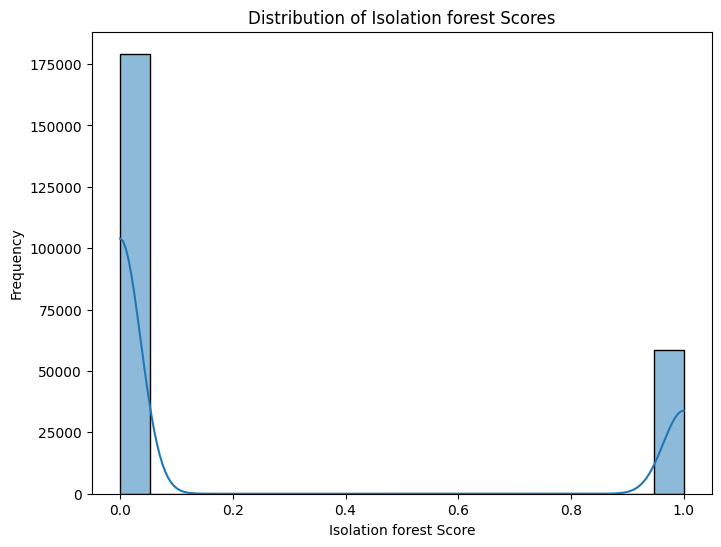

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(df['isolation_forest_scores'], kde=True)
plt.title("Distribution of Isolation forest Scores")
plt.xlabel("Isolation forest Score")
plt.ylabel("Frequency")
plt.show()

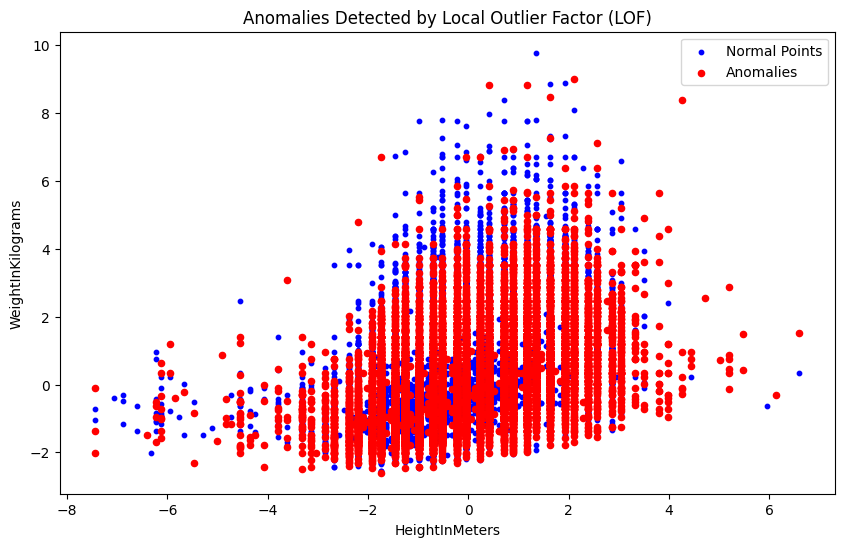

In [19]:
x = df['HeightInMeters']
y = df['WeightInKilograms']

# Separate normal points and anomalies based on LOF scores
normal_points = df[df['lof_scores'] == 0]
anomalies = df[df['lof_scores'] == 1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot normal points
plt.scatter(normal_points['HeightInMeters'], normal_points['WeightInKilograms'], 
            color='blue', s=10, label='Normal Points')

# Plot anomalies
plt.scatter(anomalies['HeightInMeters'], anomalies['WeightInKilograms'], 
            color='red', s=20, label='Anomalies')

# Labels and title
plt.xlabel('HeightInMeters')
plt.ylabel('WeightInKilograms')
plt.title('Anomalies Detected by Local Outlier Factor (LOF)')
plt.legend()
plt.show()


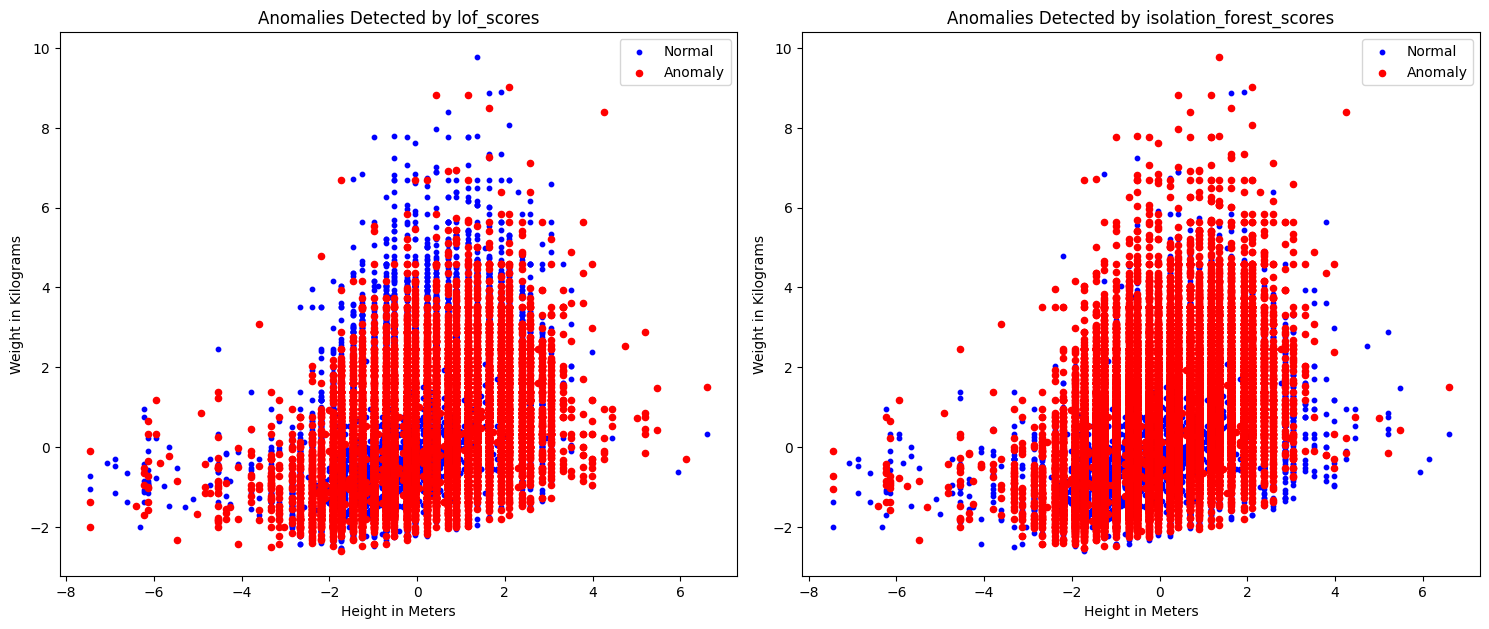

In [27]:
import matplotlib.pyplot as plt

# Define the list of method prediction columns directly
prediction_columns = ['lof_scores','isolation_forest_scores']

# Plot each method's detected anomalies
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for i, method in enumerate(prediction_columns):
    if method not in df.columns:
        print(f"Column '{method}' is missing in the DataFrame.")
        continue  # Skip to the next method if this column doesn't exist
    
    # Separate normal points and anomalies
    normal = df[df[method] == 0]
    anomalies = df[df[method] == 1]
    
    ax = axes[i]
    ax.scatter(normal['HeightInMeters'], normal['WeightInKilograms'], color='blue', s=10, label='Normal')
    ax.scatter(anomalies['HeightInMeters'], anomalies['WeightInKilograms'], color='red', s=20, label='Anomaly')
    ax.set_title(f'Anomalies Detected by {method}')
    ax.set_xlabel('Height in Meters')
    ax.set_ylabel('Weight in Kilograms')
    ax.legend()

# Remove any empty subplots if there are any left
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
